In [1]:
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.typing import NDArray
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from matplotlib import pyplot as plt

train_df = pd.read_csv('train_hw.csv')
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,20,RL,NaN,8750,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,8,2009,WD,Normal,148500
1,2,160,RM,24.0,2368,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2009,WD,Normal,125000
2,3,60,RL,80.0,9760,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,167900
3,4,120,RM,NaN,4500,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,165000
4,5,80,RL,NaN,14112,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,180500


In [2]:
test_df = pd.read_csv('test_hw.csv')
test1_df = test_df.copy()
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,190,RL,75.0,10382,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,3,2006,ConLD,Normal
1,2,20,RL,NaN,10708,Pave,NaN,IR1,Lvl,AllPub,...,142,0,NaN,GdWo,NaN,0,11,2009,COD,Normal
2,3,60,RL,NaN,24682,Pave,NaN,IR3,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal
3,4,160,RM,42.0,3964,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal
4,5,20,RL,75.0,10125,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,2,2008,WD,Normal


In [3]:
train_df["Exterior2nd"] = train_df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
train_df["GarageYrBlt"] = train_df["GarageYrBlt"].where(train_df.GarageYrBlt <= 2010, train_df.YearBuilt)
train_df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
        }, inplace=True,)

In [4]:
test_df["Exterior2nd"] = test_df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
test_df["GarageYrBlt"] = test_df["GarageYrBlt"].where(test_df.GarageYrBlt <= 2010, train_df.YearBuilt)
test_df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
        }, inplace=True,)

In [5]:
cat_df = train_df.select_dtypes(include=['object'])

In [6]:
num_df = train_df.select_dtypes(exclude=['object'])

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 81 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                1168 non-null   int64  
 1   MSSubClass        1168 non-null   int64  
 2   MSZoning          1168 non-null   object 
 3   LotFrontage       959 non-null    float64
 4   LotArea           1168 non-null   int64  
 5   Street            1168 non-null   object 
 6   Alley             71 non-null     object 
 7   LotShape          1168 non-null   object 
 8   LandContour       1168 non-null   object 
 9   Utilities         1168 non-null   object 
 10  LotConfig         1168 non-null   object 
 11  LandSlope         1168 non-null   object 
 12  Neighborhood      1168 non-null   object 
 13  Condition1        1168 non-null   object 
 14  Condition2        1168 non-null   object 
 15  BldgType          1168 non-null   object 
 16  HouseStyle        1168 non-null   object 


Зависимость целевой переменной от числового признака

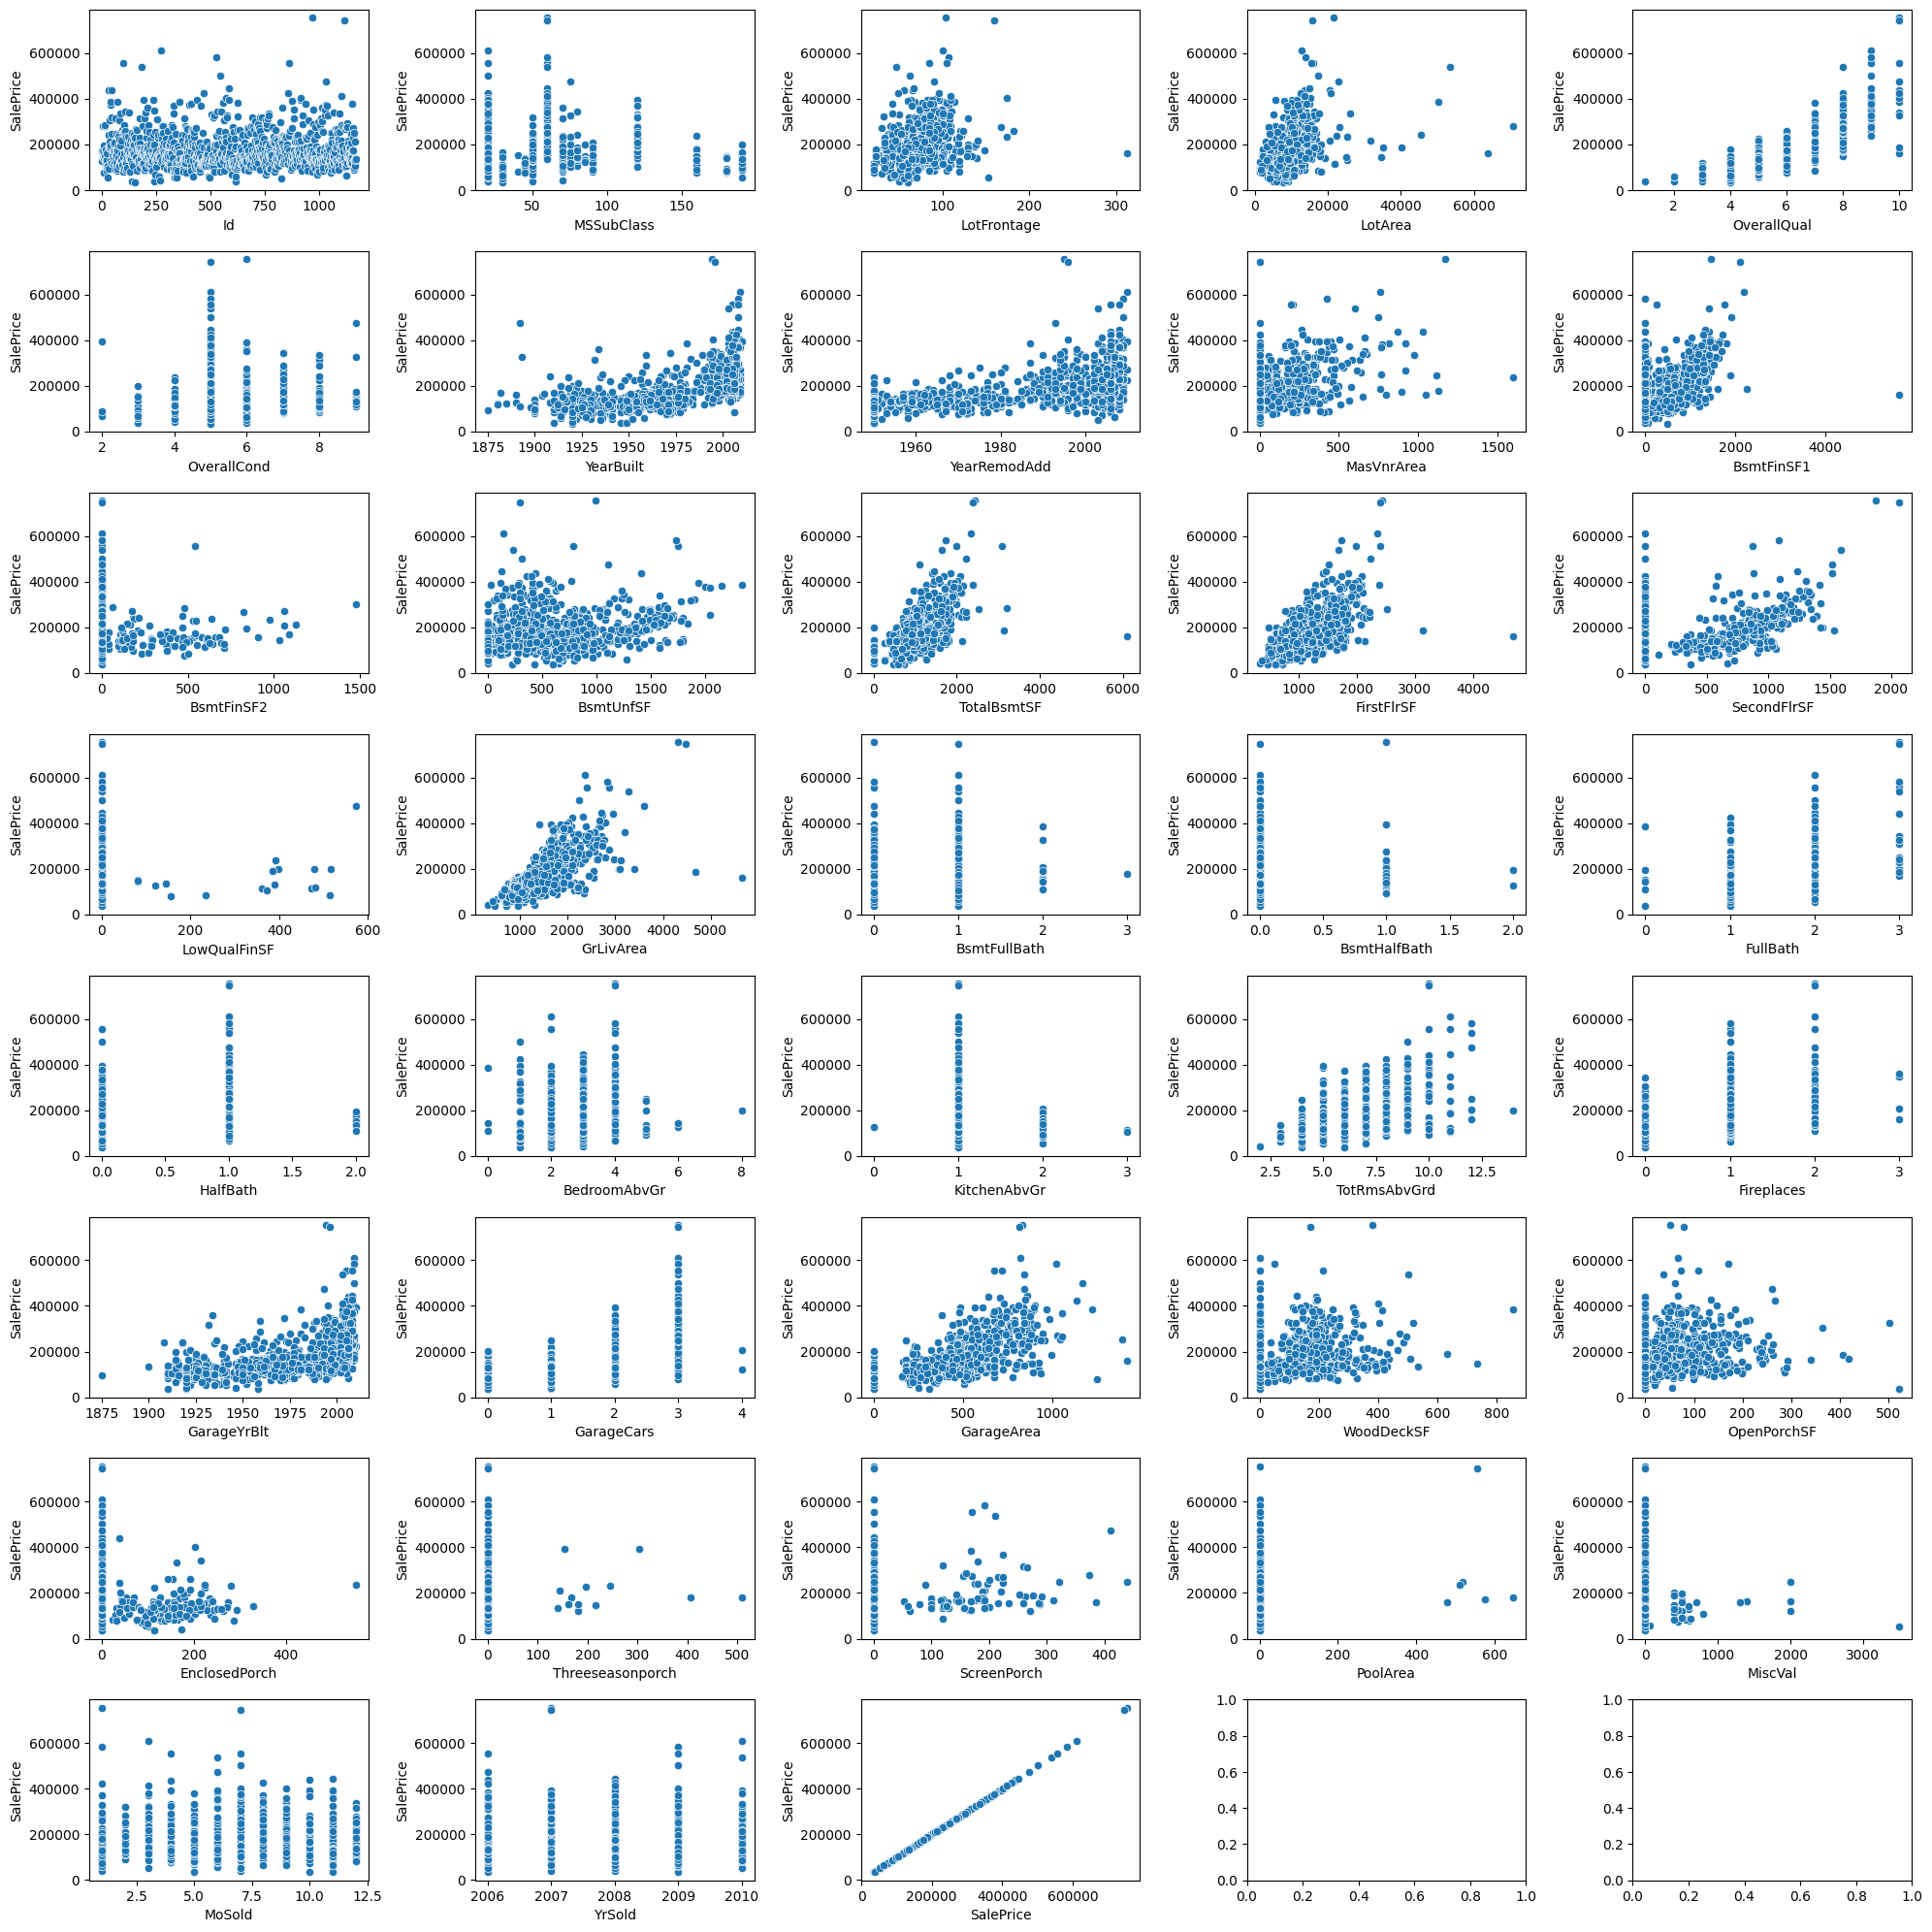

In [8]:
fig, axes = plt.subplots(8, 5, figsize=(20, 20))
axes_flattened = axes.reshape(-1)
for i in range(len(num_df.columns)):
    ax = axes_flattened[i]
    sns.scatterplot(
        x=num_df.iloc[:, i],
        y='SalePrice',
        data=num_df.dropna(),
        ax=ax,
    )
fig.tight_layout(pad=1.0)

Удаление коррелирующих признаков

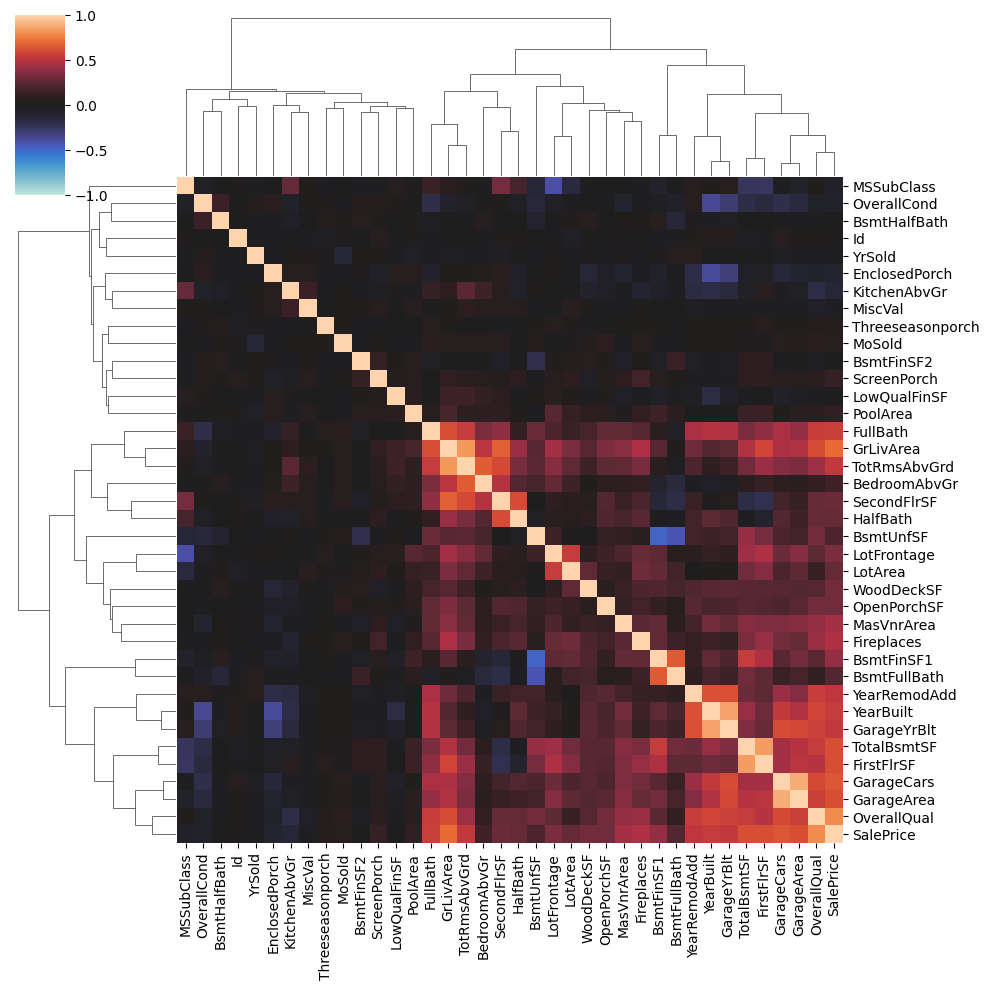

In [9]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(num_df, annot=None)

In [10]:
# Создаем матрицу корреляций и преобразуем в пары
correlation_matrix = num_df.corr()
correlation_pairs = correlation_matrix.unstack().reset_index()
correlation_pairs.columns = ['sign1', 'sign2', 'correlation']

# убираем дубликаты и корреляцию признака с самим собой
correlation_pairs = correlation_pairs[
    (correlation_pairs['sign1'] != correlation_pairs['sign2']) 
].drop_duplicates()

# Находим сильно коррелирующие пары (>0.75)
high_corr_pairs = correlation_pairs[correlation_pairs['correlation'] > 0.75]
print(f"Найдено пар с корреляцией > 0.75: {len(high_corr_pairs)}")

high_corr_pairs.sort_values('correlation', ascending=False).head(10)

Найдено пар с корреляцией > 0.75: 10


,sign1,sign2,correlation
1015,GarageCars,GarageArea,0.878024
1052,GarageArea,GarageCars,0.878024
956,GarageYrBlt,YearBuilt,0.851580
253,YearBuilt,GarageYrBlt,0.851580
506,FirstFlrSF,TotalBsmtSF,0.841182
469,TotalBsmtSF,FirstFlrSF,0.841182
890,TotRmsAbvGrd,GrLivArea,0.821870
631,GrLivArea,TotRmsAbvGrd,0.821870
189,OverallQual,SalePrice,0.794936
1410,SalePrice,OverallQual,0.794936


In [11]:
train_df.drop(
    ['GarageYrBlt','TotRmsAbvGrd','FirstFlrSF','GarageCars'],
    axis=1,
    inplace=True
)

In [12]:
test_df.drop(
    ['GarageYrBlt','TotRmsAbvGrd','FirstFlrSF','GarageCars'],
    axis=1,
    inplace=True
)

In [13]:
len(test_df)

292

Удаление пустых значений

In [14]:
nan_df = (train_df.isnull().mean() * 100).reset_index()
nan_df.columns = ['column_name', 'percentage'] 
nan_df.sort_values('percentage', ascending=False, inplace=True)
nan_df.head(10)

,column_name,percentage
68,PoolQC,99.400685
70,MiscFeature,96.318493
6,Alley,93.921233
69,Fence,81.678082
25,MasVnrType,59.417808
55,FireplaceQu,46.832192
3,LotFrontage,17.893836
56,GarageType,5.650685
57,GarageFinish,5.650685
60,GarageCond,5.650685


In [15]:
intro_srt = "Number of columns with more than"
for percent in (80, 50, 20, 5):
    print(f"{intro_srt} {percent}% NANs: {(nan_df.percentage > percent).sum()}")


Number of columns with more than 80% NANs: 4
Number of columns with more than 50% NANs: 5
Number of columns with more than 20% NANs: 6
Number of columns with more than 5% NANs: 11


In [16]:
nan_columns = list(nan_df[nan_df.percentage > 80]['column_name'])
nan_columns

['PoolQC', 'MiscFeature', 'Alley', 'Fence']

In [ ]:
print(len(train_df.columns))
train_df_dropped = train_df.drop(columns=[col for col in nan_columns if col in train_df.columns], inplace=True)
print(len(train_df_dropped.columns))

print(len(test_df))
test_df_dropped = test_df.drop(columns=[col for col in nan_columns if col in test_df.columns], inplace=True)
print(len(test_df_dropped.columns))

1163
225
292
224


Заполняем средним значением по районам и оставшиеся числовые признаки

<Axes: xlabel='Neighborhood', ylabel='GarageArea_mean'>

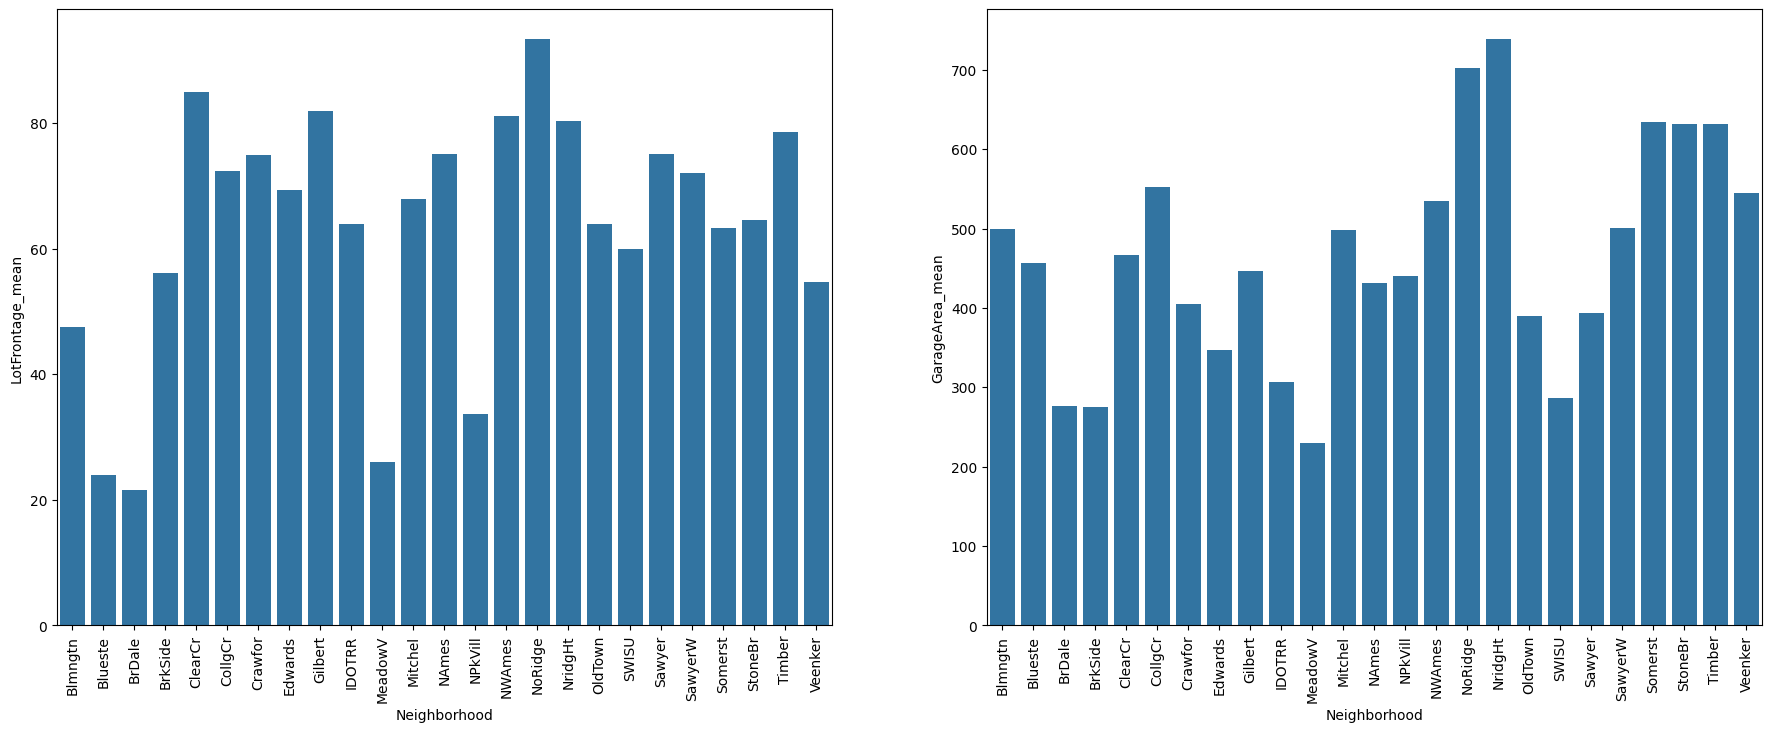

In [ ]:
neigh_grouped = train_df.groupby('Neighborhood')
neigh_lot = (
    neigh_grouped['LotFrontage'].mean().reset_index(name='LotFrontage_mean')
)
neigh_garage = (
    neigh_grouped['GarageArea'].mean().reset_index(name='GarageArea_mean')
)

fig, axes = plt.subplots(1,2,figsize=(22,8))
axes[0].tick_params(axis='x', rotation=90)
sns.barplot(x='Neighborhood', y='LotFrontage_mean', data=neigh_lot, ax=axes[0])
axes[1].tick_params(axis='x', rotation=90)
sns.barplot(x='Neighborhood', y='GarageArea_mean', data=neigh_garage, ax=axes[1])

In [19]:
train_df['LotFrontage'] = train_df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
train_df['GarageArea'] = train_df.groupby('Neighborhood')['GarageArea'].transform(lambda x: x.fillna(x.mean()))

In [ ]:
num_сols_with_missing = [col for col in num_df.columns if num_df[col].isnull().any()]
num_сols_with_missing

['LotFrontage', 'MasVnrArea']

In [21]:
num_сols_with_missing = [col for col in num_df.columns if num_df[col].isnull().any()]
num_сols_with_missing = [col for col in num_сols_with_missing if col in train_df.columns]  

# Заполнение пропусков
if num_сols_with_missing:
    train_df[num_сols_with_missing] = train_df[num_сols_with_missing].fillna(train_df[num_сols_with_missing].mean())
    test_df[num_сols_with_missing] = test_df[num_сols_with_missing].fillna(train_df[num_сols_with_missing].mean())

Заполнение модой категориальных признаков:

In [22]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'SecondFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'Threeseasonpo

In [23]:
cols = ["MasVnrType", "MSZoning", "Exterior1st", "Exterior2nd", "SaleType", "Electrical", "Functional"]
for col in cols:
    mode_val = train_df[col].mode()[0]
    train_df[col] =train_df[col].fillna(mode_val)
    test_df[col] = test_df[col].fillna(mode_val)
    

In [24]:
cat = ['GarageType','GarageFinish','BsmtFinType2','BsmtExposure','BsmtFinType1', 
       'GarageCond','GarageQual','BsmtCond','BsmtQual','FireplaceQu',"KitchenQual",
       "HeatingQC",'ExterQual','ExterCond']
train_df[cat] = train_df[cat].fillna("NA")
test_df[cat] = test_df[cat].fillna("NA")

In [25]:
print("Пропуски в cols:", train_df[cols].isnull().sum().sum())
print("Пропуски в cat:", train_df[cat].isnull().sum().sum())

Пропуски в cols: 0
Пропуски в cat: 0


Удаление признаков со слабой вариативностью

In [26]:
def get_almost_constant_columns(df, dropna=True):
    cols = []
    for i in df:
        if dropna:
            counts = df[i].dropna().value_counts()
        else:
            counts = df[i].value_counts()
        most_popular_value_count = counts.iloc[0]
        if (most_popular_value_count / len(df)) * 100 > 96:
            cols.append(i)
    return cols

In [27]:
cat_df = train_df.select_dtypes(include=['object'])
overfit_cat = get_almost_constant_columns(cat_df)
train_df = train_df.drop(overfit_cat, axis=1)
overfit_cat

['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']

In [28]:
num_df = train_df.select_dtypes(exclude=['object'])
overfit_num = get_almost_constant_columns(num_df, dropna=True)
train_df = train_df.drop(overfit_num, axis=1)
overfit_num

['LowQualFinSF', 'Threeseasonporch', 'PoolArea', 'MiscVal']

In [29]:
len(test_df)

292

Удаление выбросов

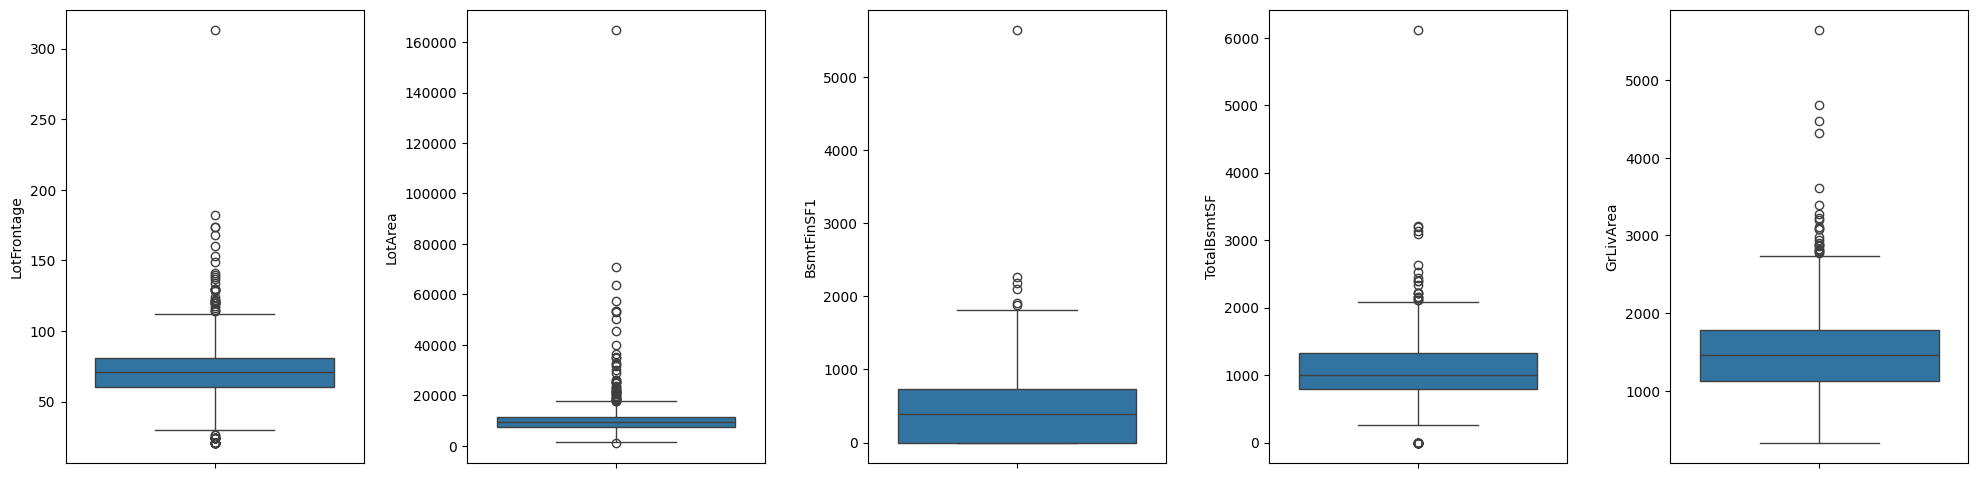

In [30]:
out_col = ['LotFrontage', 'LotArea', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea']

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for ax, col in zip(axes, out_col):
    sns.boxplot(y=train_df[col], data=train_df, ax=ax)
fig.tight_layout(pad=1.5)

In [31]:
for col, upper_bound in (
    ('LotFrontage', 200),
    ('LotArea', 100000),
    ('BsmtFinSF1', 4000),
    ('TotalBsmtSF', 5000),
    ('GrLivArea', 4000),
):
    train_df = train_df.drop(train_df[train_df[col] > upper_bound].index)
    #test_df = test_df.drop(test_df[test_df[col] > upper_bound].index) #????

In [32]:
len(test_df)

292

Feature Engineering

In [33]:
train_df['MSSubClass'].value_counts()

MSSubClass
20     447
60     230
50     102
120     73
30      57
160     51
70      47
80      43
90      43
190     20
85      14
75      13
45      11
180      9
40       3
Name: count, dtype: int64

In [34]:
train_df['MSSubClass'] = train_df['MSSubClass'].apply(str)

In [35]:
ordinal_map = {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
fintype_map = {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'NA': 0}
expose_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}
fence_map = {'GdPrv': 4,'MnPrv': 3,'GdWo': 2, 'MnWw': 1,'NA': 0}

In [36]:
ord_col = ['ExterQual','ExterCond','BsmtQual', 'BsmtCond','HeatingQC','KitchenQual','GarageQual','GarageCond', 'FireplaceQu']
for col in ord_col:
    train_df[col] = train_df[col].map(ordinal_map)
    test_df[col] = test_df[col].map(ordinal_map)

fin_col = ['BsmtFinType1','BsmtFinType2']
for col in fin_col:
    train_df[col] = train_df[col].map(fintype_map)
    test_df[col] = test_df[col].map(fintype_map)

train_df['BsmtExposure'] = train_df['BsmtExposure'].map(expose_map)
test_df['BsmtExposure'] = test_df['BsmtExposure'].map(expose_map)

In [37]:
print("Столбцы в train_df:", train_df.columns.tolist())

Столбцы в train_df: ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir', 'Electrical', 'SecondFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice']


In [38]:
train_df['TotalLot'] = train_df['LotFrontage'] + train_df['LotArea']
train_df['TotalBsmtFin'] = train_df['BsmtFinSF1'] + train_df['BsmtFinSF2']
train_df['TotalSF'] = train_df['TotalBsmtSF'] + train_df['SecondFlrSF']
train_df['TotalBath'] = train_df['FullBath'] + train_df['HalfBath']
train_df['TotalPorch'] = train_df['OpenPorchSF'] + train_df['EnclosedPorch'] + train_df['ScreenPorch']

In [39]:
test_df['TotalLot'] = test_df['LotFrontage'] + test_df['LotArea']
test_df['TotalBsmtFin'] = test_df['BsmtFinSF1'] + test_df['BsmtFinSF2']
test_df['TotalSF'] = test_df['TotalBsmtSF'] + test_df['SecondFlrSF']
test_df['TotalBath'] = test_df['FullBath'] + test_df['HalfBath']
test_df['TotalPorch'] = test_df['OpenPorchSF'] + test_df['EnclosedPorch'] + test_df['ScreenPorch']

In [40]:
train_df["LivLotRatio"] = train_df["GrLivArea"] / train_df["LotArea"]
test_df["LivLotRatio"] = test_df["GrLivArea"] / test_df["LotArea"]

In [41]:
cols = ['MasVnrArea','TotalBsmtFin','TotalBsmtSF','SecondFlrSF','WoodDeckSF','TotalPorch']

for col in cols:
    col_name = col+'_bin'
    train_df[col_name] = train_df[col].apply(lambda train_df: 1 if train_df > 0 else 0)
    test_df[col_name] = test_df[col].apply(lambda test_df: 1 if test_df > 0 else 0)

In [42]:
train_df = pd.get_dummies(train_df)

In [43]:
len(train_df.columns)

225

In [44]:
len(test_df)

292

Скейлинг

In [45]:
from sklearn.preprocessing import RobustScaler
import numpy as np

# Выбираем только числовые колонки
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
numeric_cols = numeric_cols.drop(['Id', 'SalePrice'])

scaler = RobustScaler()
train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])
test_df[numeric_cols] = scaler.transform(test_df[numeric_cols]) 

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
import numpy as np
import pandas as pd

X = train_df.drop(['Id', 'SalePrice'], axis=1)
y = train_df['SalePrice']

y = np.log1p(train_df['SalePrice']) 

numeric_features = X.select_dtypes(exclude=['object']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Пайплайн обработки с TargetEncoder
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ]), numeric_features),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('target_enc', TargetEncoder(smoothing=10)) 
    ]), categorical_features)
])

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Функция для оценки моделей
def evaluate_model(model, X_tr, y_tr, X_val, y_val, model_name=""):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_tr, y_tr)
    
    train_pred = np.maximum(pipeline.predict(X_tr), 0)
    valid_pred = np.maximum(pipeline.predict(X_val), 0)
    
    train_msle = mean_squared_log_error(y_tr, train_pred)
    valid_msle = mean_squared_log_error(y_val, valid_pred)
    
    print(f"{model_name} Scores:")
    print(f"    Train MSLE: {train_msle:.6f}")
    print(f"    Valid MSLE: {valid_msle:.6f}\n")
    
    return valid_msle, pipeline

# Обычная линейная регрессия
print("Linear Regression")
base_msle, base_model = evaluate_model(
    LinearRegression(), 
    X_train, y_train, 
    X_valid, y_valid,
    model_name="Linear Regression"
)

# Подбираем альфа для Lasso
print("\n Lasso Regression ")
best_lasso = {'alpha': None, 'score': np.inf, 'model': None}
for alpha in [0.0001, 0.001, 0.01, 0.1, 1.0]:
    model = Lasso(alpha=alpha, random_state=42, max_iter=10000)
    valid_msle, pipeline = evaluate_model(
        model, X_train, y_train, 
        X_valid, y_valid,
        model_name=f"Lasso (alpha={alpha})"
    )
    
    if valid_msle < best_lasso['score']:
        best_lasso['alpha'] = alpha
        best_lasso['score'] = valid_msle
        best_lasso['model'] = pipeline

print(f"Лучшая alpha для Lasso: {best_lasso['alpha']} с Valid MSLE: {best_lasso['score']:.6f}\n")

# Подбираем альфа для Ridge
print("\n Ridge Regression")
best_ridge = {'alpha': None, 'score': np.inf, 'model': None}
for alpha in [0.0001, 0.001, 0.01, 0.1, 1.0]:
    model = Ridge(alpha=alpha, random_state=42, max_iter=10000)
    valid_msle, pipeline = evaluate_model(
        model, X_train, y_train, 
        X_valid, y_valid,
        model_name=f"Ridge (alpha={alpha})"
    )
    
    if valid_msle < best_ridge['score']:
        best_ridge['alpha'] = alpha
        best_ridge['score'] = valid_msle
        best_ridge['model'] = pipeline

print(f"Лучшая alpha для Ridge: {best_ridge['alpha']} с Valid MSLE: {best_ridge['score']:.6f}\n")

# Выбор лучшей модели
models_comparison = [
    ('Linear Regression', base_msle, base_model),
    ('Lasso', best_lasso['score'], best_lasso['model']),
    ('Ridge', best_ridge['score'], best_ridge['model'])
]

best_model_name, best_score, best_pipeline = min(models_comparison, key=lambda x: x[1])

print("\nИТОГОВОЕ СРАВНЕНИЕ МОДЕЛЕЙ")
for name, score, _ in models_comparison:
    print(f"{name}: Valid MSLE = {score:.6f}")

print(f"\nВыбрана {best_model_name} как лучшая модель с Valid MSLE = {best_score:.6f}")

best_pipeline.fit(X, y)

X_test = test_df.drop('Id', axis=1)

# Функция для выравнивания признаков
def align_features(X_train, X_test):
    for col in numeric_features:
        if col not in X_test.columns:
            X_test[col] = X_train[col].median()
        else:
            X_test[col] = X_test[col].fillna(X_train[col].median())

    for col in categorical_features:
        if col not in X_test.columns:
            X_test[col] = X_train[col].mode()[0]
        else:
            X_test[col].fillna(X_train[col].mode()[0], inplace=True)
    
    # смотрим совпадает ли порядок и набор колонок
    X_test = X_test[X_train.columns]
    return X_test

X_test_aligned = align_features(X, X_test)

# Делаем предсказание
test_pred = np.maximum(best_pipeline.predict(X_test_aligned), 0)

# Обратное преобразование так как использовали логарифм
test_pred = np.expm1(test_pred)

submission = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': test_pred
})

submission_file = 'submission31.csv'
submission.to_csv(submission_file, index=False)

Linear Regression
Linear Regression Scores:
    Train MSLE: 0.000052
    Valid MSLE: 0.000080


 Lasso Regression 
Lasso (alpha=0.0001) Scores:
    Train MSLE: 0.000055
    Valid MSLE: 0.000064

Lasso (alpha=0.001) Scores:
    Train MSLE: 0.000071
    Valid MSLE: 0.000054

Lasso (alpha=0.01) Scores:
    Train MSLE: 0.000110
    Valid MSLE: 0.000074

Lasso (alpha=0.1) Scores:
    Train MSLE: 0.000343
    Valid MSLE: 0.000309

Lasso (alpha=1.0) Scores:
    Train MSLE: 0.000916
    Valid MSLE: 0.000935

Лучшая alpha для Lasso: 0.001 с Valid MSLE: 0.000054


 Ridge Regression
Ridge (alpha=0.0001) Scores:
    Train MSLE: 0.000052
    Valid MSLE: 0.000080

Ridge (alpha=0.001) Scores:
    Train MSLE: 0.000052
    Valid MSLE: 0.000080

Ridge (alpha=0.01) Scores:
    Train MSLE: 0.000052
    Valid MSLE: 0.000080

Ridge (alpha=0.1) Scores:
    Train MSLE: 0.000052
    Valid MSLE: 0.000075

Ridge (alpha=1.0) Scores:
    Train MSLE: 0.000055
    Valid MSLE: 0.000063

Лучшая alpha для Ridge: 1.0 с 

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error 
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import numpy as np
import pandas as pd

X = train_df.drop(['Id', 'SalePrice'], axis=1)
y = train_df['SalePrice']

y = np.log1p(train_df['SalePrice'])

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Создание пайплайнов обработки
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Объединение трансформеров
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Создание и обучение модели
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели
model.fit(X_train, y_train)

valid_pred = model.predict(X_valid)
# Экспоненцируем предсказания и истинные значения для msle, так как мы работали с логарифмами
msle = mean_squared_log_error(np.expm1(y_valid), np.expm1(valid_pred))
print(f"MSLE: {msle:.6f}")

# Переобучение на всех данных
model.fit(X, y)

# Убедимся, что порядок столбцов совпадает
test_X = test_df[X.columns]

# Предсказание
test_pred = model.predict(test_X)
test_pred = np.expm1(test_pred)  

submission = pd.DataFrame({
    'Id': test_df['Id'].values,
    'SalePrice': test_pred
})

submission.to_csv('submission4.csv', index=False)

print("\nФайл submission4.csv успешно создан!")
print("Первые 5 строк:")
print(submission.head())

Mean Squared Logarithmic Error: 0.012316

Файл submission41.csv успешно создан!
Первые 5 строк:
   Id      SalePrice
0   1  123643.340908
1   2  189342.012401
2   3  189777.461879
3   4  199050.891788
4   5  164554.511165


Из вышеописанных результатов мы можем сделать вывод что Lasso с alpha=0.001 показал лучший результат (Valid MSLE: 0.000054), превзойдя Ridge и Linear Regression. Но результаты в Kaggle поазали, что решение без регуляризации немного лучше, чем с регуляризацией. (разница между результатами 0,00057). Если сравнивать между энкодингами, то отличий в результатах не наблюдается (сравнивались OneHotEncoder и TargetEncoder)